As a baseline method, I've implemented Criminsi's method for single view metrology, using distances between parallel planes. The basic procedure is as follows:

- Find vanishing points of three pairs of parallel lines from the scene, use this to establish a coordinate frame and find the projection matrix, up to an unknown scale.
- Next, we provide two points on each axis a known distance apart, recovering said unknown scale
- We can now find the distances between either arbitrary ground plane points, or corresponding points on the ground plane and a parallel plane

References:
- [The Paper](papers/Criminsi-SVM.pdf)
- [Zheng Rui's Explainer](https://zhengrui.github.io/former/singleviewmetrology.html)
- [CMU Slides](https://www.cs.cmu.edu/~ph/869/www/notes/criminisi.pdf)
- [Robert Collins' Method for Computing Vanishing Points](https://www.cs.cmu.edu/~ph/869/www/notes/vanishing.txt)

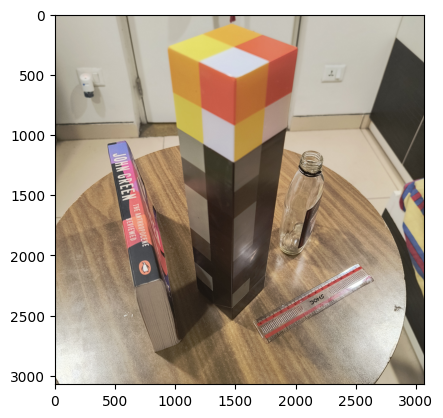

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

%matplotlib inline

name = "torch_2"
img = cv.imread(f"data/{name}.jpg")

_ = plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [2]:
get_color = lambda i: (127 * (i % 3), 127 * ((i + 1) % 3), 127 * ((i + 2) % 3))

make_homogeneous = lambda pt: np.r_[pt, 1]
make_heterogeneous = lambda pt: (pt / pt[-1])[:-1]

# for pts in homogeneous coords
get_joining_line = lambda pt1, pt2: np.cross(pt1, pt2)
intersect_lines = get_joining_line

In [32]:
# (x1, x2) || (x3, x4), (y1, y2) || (y3, y4) for ref plane, (z1, z2) || (z3, z4) for height
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
pts = plt.ginput(12, 5000)

parallel_lines = np.zeros((3, 2, 2, 2))

for i in range(6):
	dim = i // 2
	line = i % 2

	parallel_lines[dim][line][0] = np.array(pts[i * 2])
	parallel_lines[dim][line][1] = np.array(pts[i * 2 + 1])

y = input("type y to save:")

if (y.lower())[0] == "y":
	np.save(f"criminsi_data/{name}_parallel_lines.npy", parallel_lines)
	print("saved")

saved


In [33]:
parallel_lines = np.load(f"criminsi_data/{name}_parallel_lines.npy")

axes = parallel_lines[:, 0, :]
axes

array([[[1470.6090468 , 2541.93335885],
        [1735.61988012, 2280.27709304]],

       [[1470.6090468 , 2541.93335885],
        [1185.47080841, 2283.63166055]],

       [[1470.6090468 , 2541.93335885],
        [1494.09101937,  549.32025766]]])

In [34]:
parallel_lines.shape

(3, 2, 2, 2)

Now that we've established the axes, we find their vanishing points to recover the extrinsic rotation matrix & estimate the camera focal length

We can simply intersect our paired parallel lines to find these vanishing points

In [36]:
def compute_vanishing_points(ends_1, ends_2):
	e1 = make_homogeneous(ends_1[0])
	e2 = make_homogeneous(ends_1[1])
	e3 = make_homogeneous(ends_2[0])
	e4 = make_homogeneous(ends_2[1])

	l1 = get_joining_line(e1, e2)
	l2 = get_joining_line(e3, e4)

	return intersect_lines(l1, l2)

vps = np.zeros((3, 3))

for j in range(3):
	vps[:, j] = compute_vanishing_points(parallel_lines[j, 0], parallel_lines[j, 1])

vps

array([[ 3.71098475e+08,  2.15069680e+08, -7.54848582e+08],
       [-9.63765507e+07,  1.13175301e+08, -2.33486862e+09],
       [ 6.76087641e+04, -6.74962328e+04, -5.21379703e+05]])

In [37]:
# pick an origin
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
origin = np.array(plt.ginput(1)[0])

y = input("type y to save:")

if (y.lower())[0] == "y":
	np.save(f"criminsi_data/{name}_origin.npy", origin)
	print("saved")

saved


In [38]:
origin = np.load(f"criminsi_data/{name}_origin.npy")

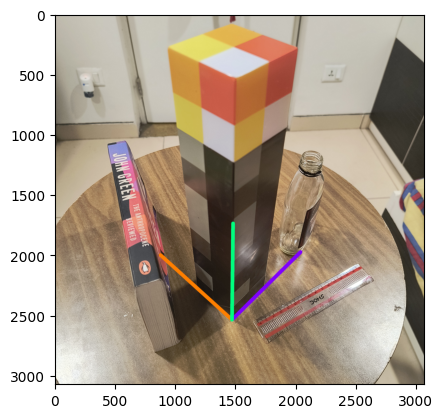

In [39]:
%matplotlib inline

axis_guys = img.copy()

length = 400

for i, axis in enumerate(axes):
	axis_dir = axis[1] - axis[0]
	axis_dir /= np.linalg.norm(axis_dir) / 2

	pt_a = np.rint(origin).astype(np.uint64)
	pt_b = np.rint(origin + length * axis_dir).astype(np.uint64)

	cv.line(axis_guys, pt_a, pt_b, get_color(i+2), 30)

plt.imshow(cv.cvtColor(axis_guys, cv.COLOR_BGR2RGB))

In [40]:
h, w, _ = img.shape

img_big = 255 * np.ones((10000, 11000, 3), dtype=np.uint16)

top_left = np.array([4200, 3500])

img_big[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w] = img

In [41]:
make_heterogeneous(vps[:, 0]) + top_left, make_heterogeneous(vps[:, 1]) + top_left

(array([9688.91079347, 2074.49619125]), array([1013.6046939 , 1823.23529799]))

In [64]:
vps_guy = img_big.copy()

h, w, _ = img_big.shape

for axis in [0, 1, 2]:
	vp_t = make_heterogeneous(vps[:, axis])

	for i, l in enumerate(parallel_lines[axis]):
		dir = l[1] - l[0]
		dir /= np.linalg.norm(dir)

		t = 8000

		if np.sign(dir[1]) != np.sign(vp_t[1] - l[0][1]):
			t *= -1

		b = (l[0] + top_left + t * dir).astype(np.uint64)
		while b[0] < 0 or b[0] >= w or b[1] < 0 or b[1] >= h:
			t *= 15/16
			b = (l[0] + top_left + t * dir).astype(np.uint64)

		a = (l[0] + top_left).astype(np.uint64)

		cv.line(vps_guy, a, b, get_color(i), 3)

	cv.circle(vps_guy, (vp_t + top_left).astype(np.uint64), 30, get_color(2), 40)

%matplotlib Qt
plt.imshow(cv.cvtColor(vps_guy, cv.COLOR_BGR2RGB))
cv.imwrite(f"criminsi_output/{name}_vanishing_points.jpg", vps_guy)

True

Now, we can recover the projection matrix up to an unknown scale, using the paper's method

In [60]:
P = np.zeros((3, 4))

P[:, :3] = vps

l_inf = get_joining_line(vps[:, 0], vps[:, 1])
l_inf /= np.linalg.norm(l_inf)
print(l_inf)

P[:, 3] = l_inf

P

[-1.82790587e-05  6.31122606e-04  9.99999801e-01]


array([[ 3.71098475e+08,  2.15069680e+08, -7.54848582e+08,
        -1.82790587e-05],
       [-9.63765507e+07,  1.13175301e+08, -2.33486862e+09,
         6.31122606e-04],
       [ 6.76087641e+04, -6.74962328e+04, -5.21379703e+05,
         9.99999801e-01]])

With this, we can establish scale per axis and measure distances. The case of measuring distances b/w parallel planes is of particular interest to us, and we can use the established height of the torch (28.1cm) to recover $\alpha$.

In [81]:
height = 28.1

Text(1580, 1500, '28.1cm')

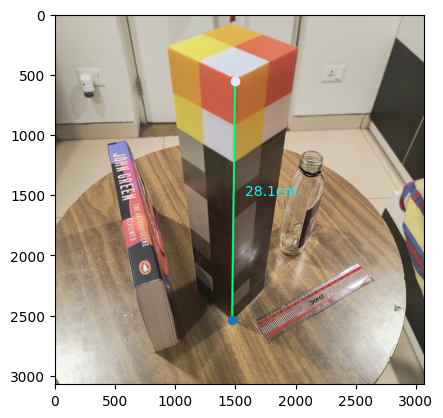

In [89]:
%matplotlib inline

ref_height_guy = np.copy(img)

cv.line(ref_height_guy, parallel_lines[2, 0, 0].astype(np.uint64), parallel_lines[2, 0, 1].astype(np.uint64), get_color(1), 15)
plt.imshow(cv.cvtColor(ref_height_guy, cv.COLOR_BGR2RGB))
plt.scatter(origin[0], origin[1])
plt.scatter(parallel_lines[2, 0, 1, 0], parallel_lines[2, 0, 1, 1], c="lavender")
plt.text(1580, 1500, f"{height}cm", {"color": "cyan"})

In [99]:
b = make_homogeneous(origin)
t = make_homogeneous(parallel_lines[2, 0, 1])

v = P[:, 2]

alpha = -np.linalg.norm(np.cross(b, t)) / (np.dot(l_inf, b) * np.linalg.norm(np.cross(v, t)) * height)

alpha

np.float64(-1.3420945579891892e-08)

First, we try to measure another vertical line for the torch, to see how consistent our solution is

In [115]:
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
alt_line_pts = np.array(plt.ginput(2, 500))

alt_line_pts

array([[1737.23488849, 2265.63822541],
       [2014.11402667,  283.93023643]])

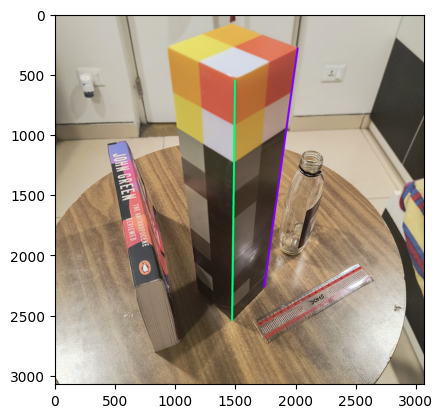

In [116]:
%matplotlib inline

alt_line_guy = np.copy(ref_height_guy)
cv.line(alt_line_guy, alt_line_pts[0].astype(np.uint64), alt_line_pts[1].astype(np.uint64), get_color(2), 15)

plt.imshow(cv.cvtColor(alt_line_guy, cv.COLOR_BGR2RGB))

In [118]:
b = make_homogeneous(alt_line_pts[0])
t = make_homogeneous(alt_line_pts[1])

alt_height = -np.linalg.norm(np.cross(b, t)) / (np.dot(l_inf, b) * np.linalg.norm(np.cross(v, t)) * alpha)
alt_height

np.float64(28.173989117795116)

This gives us a margin of error of 0.2%

In [119]:
(28.1739 - 28.1) / 28.1

0.002629893238434103

Next, we can try measuring other objects, such as the book

In [140]:
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
book_pts = np.array(plt.ginput(2, 500))

book_pts

array([[1020.17532468, 2737.37012987],
       [ 887.18831169, 2180.48701299]])

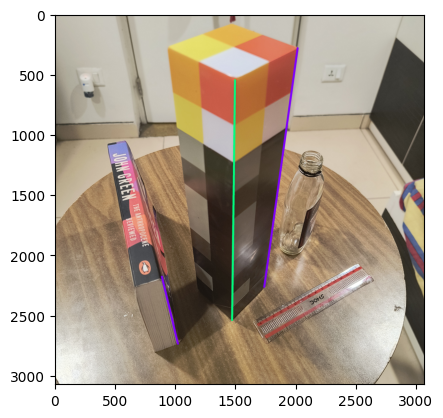

In [141]:
%matplotlib inline

book_height_guy = np.copy(alt_line_guy)
cv.line(book_height_guy, book_pts[0].astype(np.uint64), book_pts[1].astype(np.uint64), get_color(2), 15)

plt.imshow(cv.cvtColor(book_height_guy, cv.COLOR_BGR2RGB))

In [142]:
b = make_homogeneous(book_pts[0])
t = make_homogeneous(book_pts[1])

book_height = -np.linalg.norm(np.cross(b, t)) / (np.dot(l_inf, b) * np.linalg.norm(np.cross(v, t)) * alpha)

book_height

np.float64(13.191386846756966)

The correct height, here, is 12.55cm. This means that we've successfully been able to determine the height of the book with a margin of error of ~5%

Let's repeat this for the bottle

In [143]:
%matplotlib Qt

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
bottle_pts = np.array(plt.ginput(2, 500))

bottle_pts

array([[1992.64285714, 1889.57792208],
       [2133.94155844, 1183.08441558]])

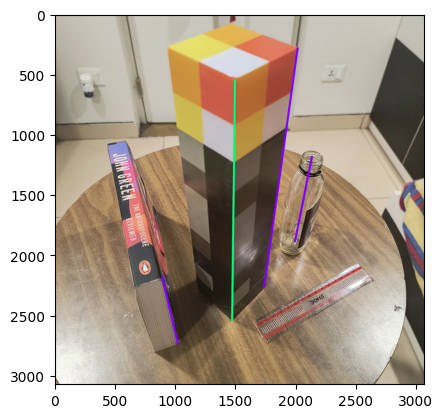

In [144]:
%matplotlib inline

bottle_height_guy = np.copy(book_height_guy)
cv.line(bottle_height_guy, bottle_pts[0].astype(np.uint64), bottle_pts[1].astype(np.uint64), get_color(2), 15)

plt.imshow(cv.cvtColor(bottle_height_guy, cv.COLOR_BGR2RGB))

In [145]:
b = make_homogeneous(bottle_pts[0])
t = make_homogeneous(bottle_pts[1])

bottle_height = -np.linalg.norm(np.cross(b, t)) / (np.dot(l_inf, b) * np.linalg.norm(np.cross(v, t)) * alpha)

bottle_height

np.float64(14.152670048120763)

The correct height here is approximately 13.5cm, which means we've once again achieved a < 5% margin of error on height calculation

One observation from this method is that it can be quite unstable, depending on how close the third vanishing point is to going off to infinity, slight perturbations in measuring lines can sometimes bump the heights quite a bit

In [146]:
# TODO: split this into a script w functions so it's easier to do experiments